#**Final Project - Chicago Traffic Commute Time Forecaster**

###CS 412

####**Group members: Elizabeth Ng, Cindy Nakhammouane**

The objective of this project is to predict average commute times in Chicago based on congestion levels, accidents, and weather conditions. The purpose is to aid commuters with understanding the impact of particular conditions on their commute time. The result of this project will be a dashboard that includes trained regression models, visuals of model evaluations in the form of plots, and maps that reveal congestion levels and predicted delay intensities.




In [ ]:
# Let's first import necessary modules and libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

#1. Data Aquisition & Cleaning


1.   Inspect each dataset for missing values, duplicates, and inconsistent data types.
2.   Drop irrelevant columns (e.g., administrative IDs, unused metadata).
3.   Standardize date/time formats (e.g., convert CRASH_DATE, trip start/end, congestion timestamps).
4.   Handle missing or abnormal data (impute or remove).
5.   Filter datasets to common time ranges (e.g., 2018–present or 2024–present depending on overlap).
6.   Remove or label special-case events (e.g., COVID years for CTA ridership).
7.   May need to one-hot-encode categorical features


In [ ]:
import pandas as pd

df = pd.read_csv('ChicagoTrafficTracker.csv')
df.head()

# Drop irrelevant columns
df = df.drop(columns=[
    'STREET',
    'FROM_STREET',
    'TO_STREET',
    ' COMMENTS'
])

# Remove whitespace
df.columns = df.columns.str.strip()

# Replace -1 speed with the median speed
valid_speeds = df[df['CURRENT_SPEED'] != -1]['CURRENT_SPEED']
median_speed = valid_speeds.median() # median = 23
df.loc[df['CURRENT_SPEED'] <= 0, 'CURRENT_SPEED'] = median_speed

# level < 0: faster than the median speed of 23
# level = 0: median speed, normal traffic
# level between 0-1: slightly slower than normal traffic
# level = 1: traffic jam, max congestion
df['CONGESTION_LEVEL'] = 1 - (df['CURRENT_SPEED'] / median_speed)

# Calculate travel time in minutes
df['TRAVEL_TIME_MIN'] = (df['LENGTH'] / df['CURRENT_SPEED']) * 60

df['LAST_UPDATED'] = pd.to_datetime(df['LAST_UPDATED'])

# Extract hour of day
df['HOUR_OF_DAY'] = df['LAST_UPDATED'].dt.hour

# Extract day of week
df['DAY_OF_WEEK'] = df['LAST_UPDATED'].dt.dayofweek

# Extract month
df['MONTH'] = df['LAST_UPDATED'].dt.month

df = df.drop(columns=['LAST_UPDATED', 'SEGMENTID'])

df['DIRECTION'] = df['DIRECTION'].str.strip()
df['STREET_HEADING'] = df['STREET_HEADING'].str.strip()

# Encode STREET_HEADING
street_heading_map = {'N': 1, 'E': 2, 'S': 3, 'W': 4}
df['STREET_HEADING'] = df['STREET_HEADING'].map(street_heading_map)

# Encode DIRECTION
direction_map = {
    'NB': 1,
    'NE': 2,
    'EB': 3,
    'SE': 4,
    'SB': 5,
    'SW': 6,
    'WB': 7,
    'NW': 8
}
df['DIRECTION'] = df['DIRECTION'].map(direction_map)

df

,DIRECTION,LENGTH,STREET_HEADING,START_LONGITUDE,START_LATITUDE,END_LONGITUDE,END_LATITUDE,CURRENT_SPEED,CONGESTION_LEVEL,TRAVEL_TIME_MIN,HOUR_OF_DAY,DAY_OF_WEEK,MONTH
0,7,0.370000,2,-87.617048,41.896936,-87.624241,41.896835,23,0.000000,0.965217,0,2,8
1,7,0.280000,4,-87.706169,41.882932,-87.711747,41.882818,23,0.000000,0.730435,14,2,7
2,4,0.330000,1,-87.783224,41.992665,-87.778073,41.989905,23,0.000000,0.860870,14,2,7
3,5,0.173023,3,-87.802922,41.823751,-87.803025,41.821245,23,0.000000,0.451364,14,2,7
4,3,0.907892,4,-87.680077,41.662512,-87.662540,41.662850,23,0.000000,2.368414,14,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,5,1.000000,3,-87.722605,41.764103,-87.722164,41.749573,23,0.000000,2.608696,14,1,12
1253,7,0.390000,4,-87.654543,41.954626,-87.662249,41.954515,15,0.347826,1.560000,14,1,12
1254,7,0.500000,4,-87.713605,41.793415,-87.723158,41.793342,29,-0.260870,1.034483,14,1,12
1255,7,1.535624,2,-87.588803,41.660093,-87.618452,41.659245,41,-0.782609,2.247254,14,1,12


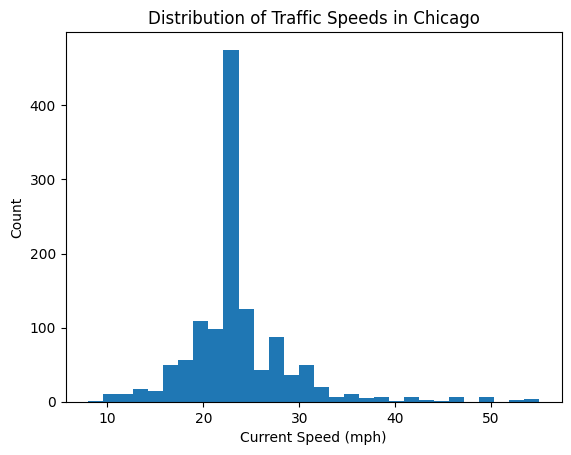

In [ ]:
plt.figure()
plt.hist(df['CURRENT_SPEED'], bins=30)
plt.xlabel("Current Speed (mph)")
plt.ylabel("Count")
plt.title("Distribution of Traffic Speeds in Chicago")
plt.show()

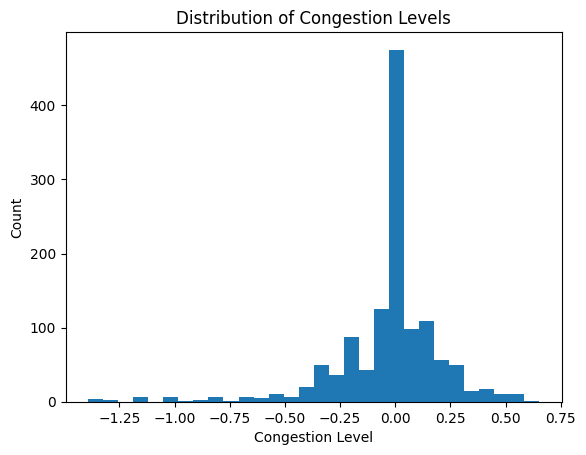

In [ ]:
plt.figure()
plt.hist(df['CONGESTION_LEVEL'], bins=30)
plt.xlabel("Congestion Level")
plt.ylabel("Count")
plt.title("Distribution of Congestion Levels")
plt.show()


#2. Feature Engineering

1. Compute average commute times per route or region using Taxi Trips or congestion data (sum length ÷ speed).
2. Create aggregated congestion indicators (e.g., average congestion level per hour or weekday).
3. Encode weather features (rain intensity, temperature, humidity, etc.).
4. Add temporal features (hour, day of week, month, season).
5. Merge all features by matching timestamps and location.
6. Perform correlation analysis to identify key predictors.


In [ ]:
#Features
print(df.columns)

Index(['DIRECTION', 'LENGTH', 'STREET_HEADING', 'START_LONGITUDE',
       'START_LATITUDE', 'END_LONGITUDE', 'END_LATITUDE', 'CURRENT_SPEED',
       'CONGESTION_LEVEL', 'TRAVEL_TIME_MIN', 'HOUR_OF_DAY', 'DAY_OF_WEEK',
       'MONTH'],
      dtype='object')


#2.5 Train/Val/Test
Data will be split chronologically: 70% training / 15% validation / 15% testing in the future, but for here its 80% training / 20% testing split.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


X = df[['DIRECTION', 'LENGTH', 'STREET_HEADING', 'START_LONGITUDE',
       'START_LATITUDE', 'END_LONGITUDE', 'END_LATITUDE', 'CURRENT_SPEED',
       'CONGESTION_LEVEL', 'HOUR_OF_DAY', 'DAY_OF_WEEK',
       'MONTH']]  # df with only feature

y = df['TRAVEL_TIME_MIN'] # df of label only

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#Plots
Make functions to make each plot/graph and call them for every model.

1.   Predicted vs Actual scatter plot (Accuracy and Variance)

2.   Residuals Plot (Bias and under/over prediction patterns)

3.   Error Distribution (Histogram of model errors)


In [ ]:
def scatter_pred_actual(y, p, title="Predicted vs Actual"):
  '''
Predicted vs. Actual Scatter Plot
  For a good model, the points should form a tight cluster around a diagonal line,
  indicating that predicted and actual values are similar.

  - If points follow the diagonal → good predictions
  - If points curve outward or flatten → linear regression underfits (expected!)
  - If there’s a funnel shape → heteroskedasticity (expected in traffic)
'''

  plt.figure(figsize=(3, 3))
  plt.scatter(y, p, s=6, alpha=0.3)
  m = max(y.max(), p.max())
  plt.plot([0,m],[0,m], lw=2)
  plt.xlabel("Actual Commute Time (min)")
  plt.ylabel("Predicted Commute Time (min)")
  plt.title(title)
  plt.show()

def residuals_plot(y, p, title="Residuals vs Prediction"):
  '''
Residuals Plot
  Reveals patterns in the errors, shows residuals randomly scattered around zero if model is appropriate.

  - Should look randomly scattered → means linear regression is okay
  - If you see a curve, slope, structure, some pattern → nonlinearity → upgrade to Random Forest / XGBoost
  - If spread increases with prediction → heteroskedasticity (normal for traffic data)
'''

  r = y - p
  plt.figure(figsize=(3, 3))
  plt.scatter(p, r, s=6, alpha=0.3)
  plt.axhline(0, c="k")
  plt.xlabel("Predicted (min)")
  plt.ylabel("Residual (min)")
  plt.title(title)
  plt.show()

def error_hist(y, p, title="Error Distribution"):
  '''
Error Distribution
  Histogram of model errors
  X-axis: This axis represents the range of error values, also known as residuals
  Y-axis: This axis represents the frequency

  - If errors are centered ~0 → good
  - Skewed right → model underpredicts rush-hour times
  - Long tail → model struggles with congested routes (expected)
'''

  r = (p - y)
  plt.figure(figsize=(3, 3))
  plt.hist(r, bins=40)
  plt.title(title)
  plt.xlabel("Error (min)")
  plt.ylabel("Count")
  plt.show()

#3. Baseline Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###3.2 Linear Regression MAE, RMSE, R², Relative Error
Calculate these target values for each model

In [ ]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print(f"RMSE: {rmse:.2f} minutes AKA {rmse * 60:.2f} seoconds")
print("MAE:", mae)
print(f"MSE:  {mse:.2f}")
print(f"R²:   {r2:.3f}")

# Brief Evaluation
results = (
    pd.DataFrame({"actual": y_test, "predicted": y_pred})
    .reset_index(drop=True)
)
results.head(10)



Linear Regression Results:
RMSE: 0.14 minutes AKA 8.31 seoconds
MAE: 0.08272097374290903
MSE:  0.02
R²:   0.956


,actual,predicted
0,1.875000,1.736417
1,1.304348,1.284015
2,1.541123,1.498003
3,1.330435,1.335175
4,1.578947,1.566159
5,1.375000,1.478668
6,2.250000,2.230075
7,1.363636,1.458547
8,1.092857,1.086973
9,1.304348,1.347834


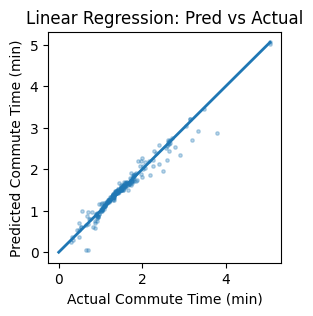

In [ ]:
#Plots
scatter_pred_actual(y_test, y_pred, "Linear Regression: Pred vs Actual")

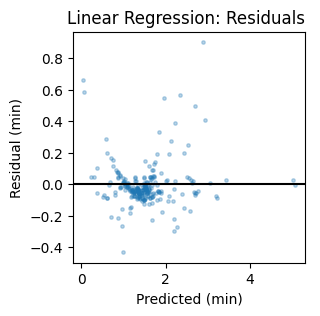

In [ ]:
residuals_plot(y_test, y_pred, "Linear Regression: Residuals ")

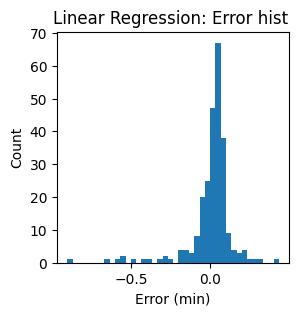

In [ ]:
error_hist(y_test, y_pred, "Linear Regression: Error hist ")

Feature Importance

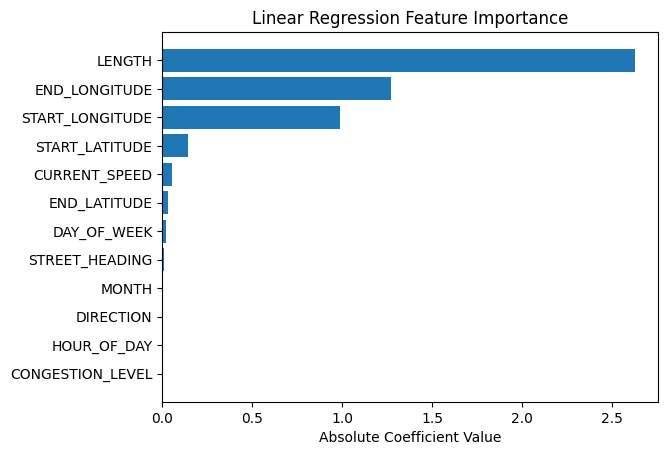

In [ ]:
import pandas as pd

importance = model.coef_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": np.abs(importance),
    "coef": importance
}).sort_values("importance", ascending=False)

plt.barh(feat_importance["feature"], feat_importance["importance"])
plt.xlabel("Absolute Coefficient Value")
plt.title("Linear Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()


Learning Curve

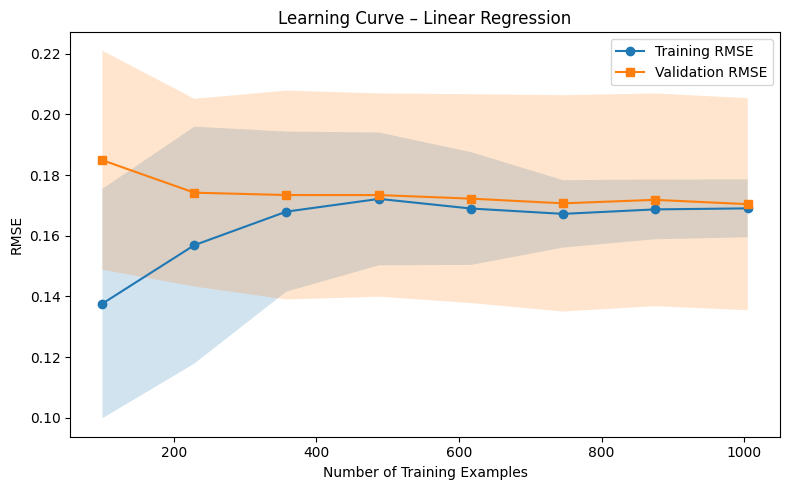

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X,
    y,
    cv=5,                          # 5-fold cross-validation
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8),  # from 10% to 100% of data
    shuffle=True,
    random_state=42,
)

# Convert from negative MSE to RMSE
train_rmse = np.sqrt(-train_scores)
test_rmse = np.sqrt(-test_scores)

# Take mean and std across folds
train_mean = train_rmse.mean(axis=1)
train_std = train_rmse.std(axis=1)
test_mean = test_rmse.mean(axis=1)
test_std = test_rmse.std(axis=1)

plt.figure(figsize=(8, 5))

plt.plot(train_sizes, train_mean, marker="o", label="Training RMSE")
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2,
)

plt.plot(train_sizes, test_mean, marker="s", label="Validation RMSE")
plt.fill_between(
    train_sizes,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.2,
)

plt.xlabel("Number of Training Examples")
plt.ylabel("RMSE")
plt.title("Learning Curve – Linear Regression")
plt.legend()
plt.tight_layout()
plt.show()

#4. Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)

###4.2 Random Forest MAE, RMSE, R², Relative Error
Calculate these target values for each model

In [ ]:
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"RMSE: {rmse:.2f} minutes AKA {rmse * 60:.2f} seoconds")
print("MAE:", mae)
print(f"MSE:  {mse:.2f}")
print(f"R²:   {r2:.3f}")

Random Forest Results:
RMSE: 0.17 minutes AKA 9.93 seoconds
MAE: 0.06512228595633394
MSE:  0.03
R²:   0.937


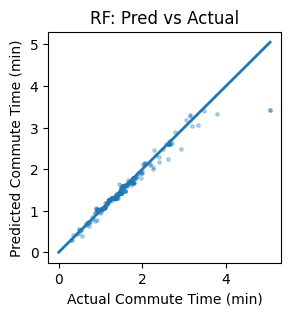

In [ ]:
scatter_pred_actual(y_test, y_pred_rf, "RF: Pred vs Actual")

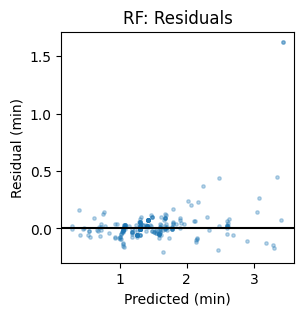

In [ ]:
residuals_plot(y_test, y_pred_rf, "RF: Residuals")

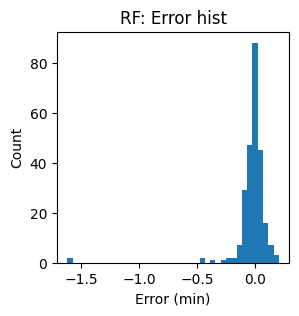

In [ ]:
error_hist(y_test, y_pred_rf, "RF: Error hist")

#5. XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [1, 2, 3],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [0, 1, 2]
}

model2 = XGBRegressor()

grid = GridSearchCV(model2, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

best_xgb_model = grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)


{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


###5.2 XGBoost MAE, RMSE, R², Relative Error
Calculate these target values for each model

In [ ]:
# Evaluation
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print(f"RMSE: {rmse:.2f} minutes AKA {rmse * 60:.2f} seoconds")
print("MAE:", mae)
print(f"MSE:  {mse:.2f}")
print(f"R²:   {r2:.3f}")

XGBoost Results:
RMSE: 0.16 minutes AKA 9.43 seoconds
MAE: 0.044248524357084415
MSE:  0.02
R²:   0.943


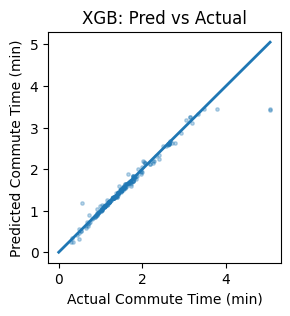

In [ ]:
#Plot
scatter_pred_actual(y_test, y_pred_xgb, "XGB: Pred vs Actual")


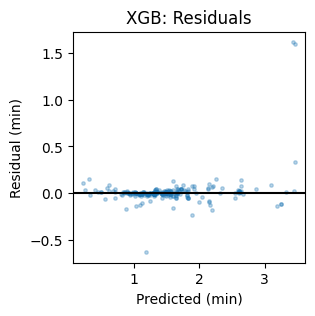

In [ ]:
residuals_plot(y_test, y_pred_xgb, "XGB: Residuals")


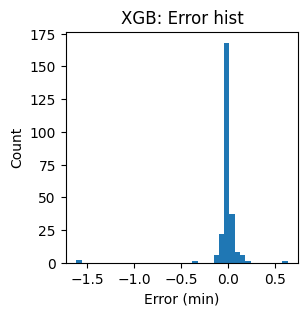

In [ ]:
error_hist(y_test, y_pred_xgb, "XGB: Error hist")

#9. Export as Pickle for Frontend

In [ ]:
import joblib
import pandas as pd

final_model = model

joblib.dump(final_model, "travel_time_model.pkl")


['travel_time_model.pkl']